# Visualization of Crescent City tsunami inundation 

This notebook illustrates how to make some simple plots of geodata using the [matplotlib](http://matplotlib.org/index.html) package.  See the [matplotlib gallery](http://matplotlib.org/gallery.html) for many other examples of how to do things.

The sample data comes from a tsunami simulation of a hypothetical tsunami arising from an earthquake on the Cascadia Subduction Zone hitting Crescent City, CA.  The data set used shows the maximum depth of water at each point on a grid covering part of the harbor during the course of the simulation.  

Many simulations like this are done in order to perform probabilistic tsunami hazard assessment (PTHA).  A set of Jupyter notebooks illustrating how this is done were prepared for a workshop last autumn and also contain some other examples of how to plot data.  These can be found in the Github repository https://github.com/rjleveque/ptha_tutorial.

<img src='figures/800px-Crescent_City_California_harbor_aerial_viewUSArmyCorpofEngineeers1.jpg' width=400>

The following "magic" command makes makes the `matplotlib` plots show up right in the notebook.  If you instead give the command `%matplotlib notebook` then it is also possible to interact with plots, e.g. to zoom.  
See [Jupyter documentation](http://ipython.readthedocs.io/en/stable/interactive/plotting.html)

In [11]:
%matplotlib inline

Import numpy and matplotlib:

In [12]:
import numpy as np
import matplotlib.pyplot as plt

### Function to read a file in asc format:

There are many tools available in various packages to read geodata in a variety of formats.  Here we provide a simple function to read a file in [ESRI ASCII raster format](http://resources.esri.com/help/9.3/arcgisengine/java/GP_ToolRef/spatial_analyst_tools/esri_ascii_raster_format.htm),
which consists of a header describing the grid followed by values on the grid.

**Note:** The [data_tools.py](data_tools.py) file in this directory contains the same `read_asc_file` function, so we could have just imported from there.

In [13]:
def read_asc_file(file_path, verbose=True):
    import numpy as np
    asc_file = open(file_path, 'r')
    
    tokens = asc_file.readline().split()
    ncols = int(tokens[1])
    
    tokens = asc_file.readline().split()
    nrows = int(tokens[1])
    
    tokens = asc_file.readline().split()
    xllcorner = float(tokens[1])
    
    tokens = asc_file.readline().split()
    yllcorner = float(tokens[1])
    
    tokens = asc_file.readline().split()
    cellsize = float(tokens[1])
    
    tokens = asc_file.readline().split()
    nodata_value = float(tokens[1])
    
    if verbose:
        print "ncols = %i" % ncols
        print "nrows = %i" % nrows
        print "xllcorner = %g" % xllcorner
        print "yllcorner = %g" % yllcorner
        print "cellsize = %g" % cellsize
        print "nodata_value = %g" % nodata_value
        
    # read in all the data, assumed to be on ncols lines, 
    # each containing nrows values
    
    asc_file.close()  # close file so we can load array
    asc_data = np.loadtxt(file_path, skiprows=6)  # skip header
    
    # reshape
    values = asc_data.reshape((nrows,ncols))
    
    # flip in y because of data order
    values = np.flipud(values)    
    
    x = xllcorner + cellsize * np.arange(0,ncols)
    y = yllcorner + cellsize * np.arange(0,nrows)
    
    X,Y = np.meshgrid(x,y)
        
    asc_data_dict = {'ncols': ncols, 'nrows': nrows, 'xllcorner':xllcorner, \
                     'yllcorner':yllcorner, 'cellsize':cellsize, 'nodata_value':nodata_value, \
                     'X': X, 'Y':Y, 'values': values}
    return asc_data_dict

### Read in the data files for this example

First the file containing the maximum water depth hmax:

In [14]:
hmax_file = '../geoclaw_output/hmax_CC.asc'
hmax_data_dict = read_asc_file(hmax_file)

ncols = 146
nrows = 128
xllcorner = -124.215
yllcorner = 41.7349
cellsize = 0.000277793
nodata_value = -9999


Unpack the dictionary that is returned, extracting the grid and `hmax` values:

In [15]:
hmax = hmax_data_dict['values']
X = hmax_data_dict['X']
Y = hmax_data_dict['Y']

Do the same for the file containing topography values.  These values `topo` are the height of the topography at each point relative to some `vertical datum`, in this case Mean High Water (MHW) since this data came from a database of topography DEMs for tsunami inundation.  [Add link!]

In [16]:
topo_file = '../geoclaw_output/topo_CC.asc'
topo_data_dict = read_asc_file(topo_file, verbose=False)

topo = topo_data_dict['values']

### Plot contours of topography

The `X,Y` arrays for the `topo` are the same as for `hmax` (one should check this!)

We can do a quick and dirty plot of contours of topography:

Contour levels: [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.]


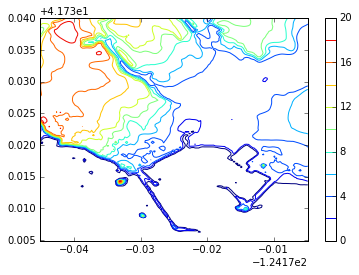

In [17]:
topo_contour_levels = np.arange(0, topo.max()+1, 2)  # 2 meter increments
print "Contour levels: %s" % topo_contour_levels
plt.contour(X,Y,topo, topo_contour_levels)
plt.colorbar()

There are several things about this plot that we might want to fix:
 - The ticklabels show only an offset rather than the full latitude longitude,
 - The aspect ratio is not correct.  At latitude theta, one degree of longitude is shorter than one degree of latitude by a factor of $cos(\theta)$.
 - For plotting data on top of the contour plot, we might want all the contour lines to be the same color, say black (which is denoted by `'k'`).

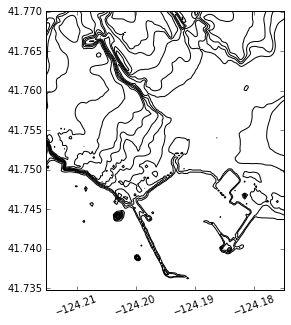

In [18]:
# Create a figure of the desired size:
fig = plt.figure(figsize=(5,5))  
ax = plt.axes()  

plt.contour(X,Y,topo, topo_contour_levels, colors='k')

# set the aspect ratio, converting 41.7 degrees to radians
ax.set_aspect(1./np.cos(41.7*np.pi/180.)) 

# get rid of the offsets:
ax.ticklabel_format(format='plain',useOffset=False)

# rotate the xtick labels so they are readable:
plt.xticks(rotation=20);   # semi-colon to suppress a message

### Plot water depth on contour plot

Here's a first attempt a plotting the maximum water depth data on the contour plot:

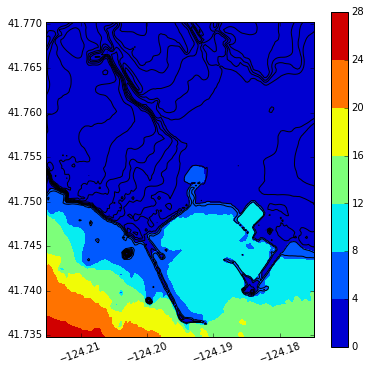

In [19]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

plt.contour(X,Y,topo, topo_contour_levels, colors='k')

ax.set_aspect(1./np.cos(41.7*np.pi/180.))
ax.ticklabel_format(format='plain',useOffset=False)
plt.xticks(rotation=20)

# Now plot the data as filled contours:
plt.contourf(X,Y,hmax)
plt.colorbar()

This plot has several problems:
- It is impossible to tell water depth 0 (no inundation) from small depths,
- The colormap and limits were set based on the data, and are revealing deep water offshore, with no information about what's happening onshore.

We can fix this by masking out the `hmax` grid in regions where either the land is dry (e.g. where `hmax < 0.001` meters) and also where `topo < 0`, i.e., anywhere there is water at high tide.

The numpy module `ma` provides masked arrays:

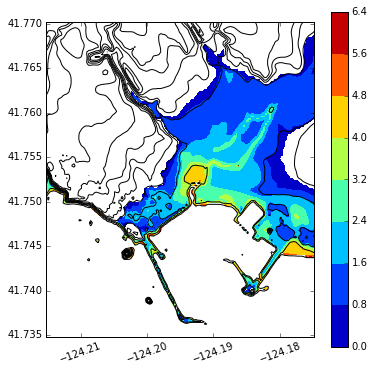

In [20]:
from numpy import ma  # masked arrays

# mask out the dry cells (e.g., where depth < 1 mm):
hmax_dry = ma.masked_where(hmax < 0.001, hmax)

# mask out the water region if we only care about onshore:
hmax_onshore = ma.masked_where(topo < 0, hmax_dry)


fig = plt.figure(figsize=(6,6))
ax = plt.axes()

plt.contour(X,Y,topo, topo_contour_levels, colors='k')

ax.set_aspect(1./np.cos(41.7*np.pi/180.))
ax.ticklabel_format(format='plain',useOffset=False)
plt.xticks(rotation=20)

plt.contourf(X,Y,hmax_onshore)
plt.colorbar()

This gives a more useful plot. We might want to tweak it further, e.g. by specifying the colormap and/or the depth levels separating colors.

To do:
- add colormap discussion
- pcolor and imshow examples
- plot on map or image rather than on contour plot